# Baseline Correction

In this notebook, we will explore different baseline correction methods implemented in the spec_tools package. For this we will use the **baseline.py** module which contains the **Baseline** class. This class provides different methods for baseline correction and smoothing of the spectral data


All this methods were implemented using the **pybaselines** package as a reference

In [1]:
import sys
sys.path.append('..')
import spec_tools

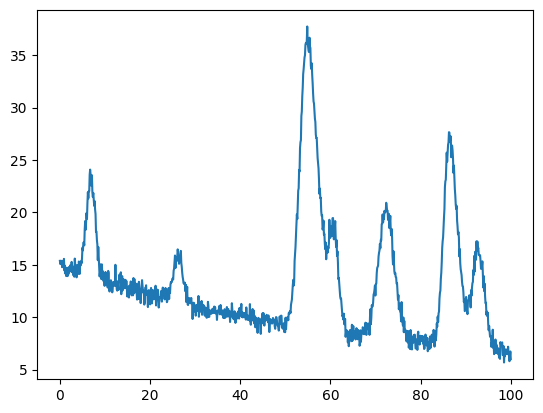

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#x,y = spec_tools.baseline.generate_random_gaussian_peaks(10,[0,100],noise_level=0.5)
x,y = spec_tools.baseline.generate_random_gaussian_with_shifted_baseline(10,[0,100],noise_level=0.5)

plt.plot(x,y)


In [3]:
# Next of we generate a Spectrum Object from the data
data = np.array([x,y]).T

spectrum = spec_tools.spectrum.Spectrum(name="Test-Data", data=data)

# Initialize the baseline class using this spectrum object

baseline1 = spec_tools.baseline.Baseline(spectrum)

# Smoothing of Noise Data

For this different approaches are implemented. The most common methods is applying a rolling average filter. This is done by the **apply_rolling_average_filter** method in the **Baseline** class.

> Note that the smoothed data gets safed in the baseline object. Thus in Jupyter executing the same code multiple times applies the filter multiple times.

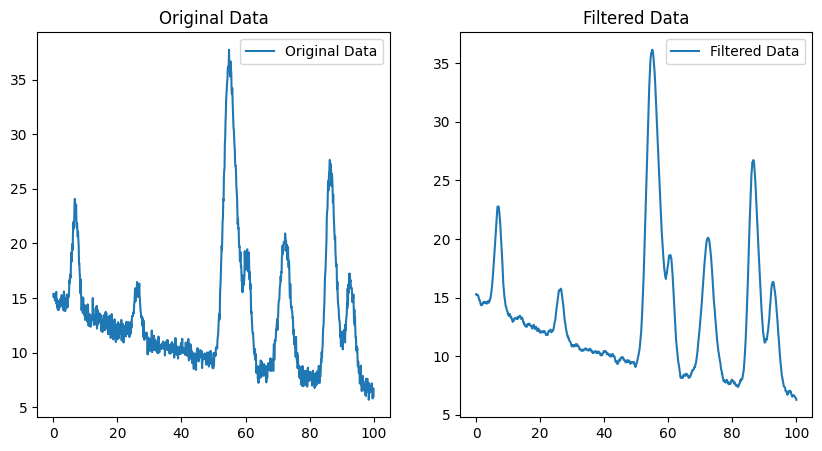

In [4]:
baseline1.apply_rolling_average_filter(window_size=10)

Another approach is to use a **Gaussian Filter**. Gaussian filters are often used in singal processing, the impuls response here is a Gaussian Function. Mathmatically this is done via convolution of a the data with a Gaussian Function.

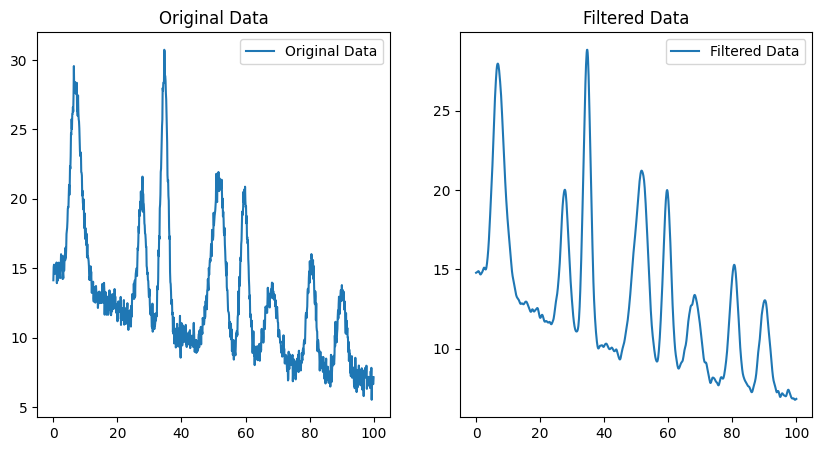

In [5]:
x1,y2 = spec_tools.baseline.generate_random_gaussian_with_shifted_baseline(10,[0,100],noise_level=0.5)
data2 = np.array([x1,y2]).T
spectrum2 = spec_tools.spectrum.Spectrum(name="Test-Data", data=data2)
baseline2 = spec_tools.baseline.Baseline(spectrum2)

baseline2.apply_gaussian_filter(sigma=3)

Another metod is to use a **Savitzky-Golay Filter**. This filter smooths the data by fitting successive sub-sets of adjacent data points with a low-degree polynomial with the method of linear-least squares. Advantage of this method is that it preserves the shape of the features such as peaks and valleys which might be lost with other smoothing methods

So we have a polynomial

\begin{equation}
y = a_0 + a_1 x + a_2 x^2 + ... + a_n x^n
\end{equation}

And minimize the squared differences between actual data points and the polynomial values

\begin{equation}
Minimize ~~ \sum_{i=-m}^{m} (y_{k+i}-\sum_{j=0}^{n} a_j x_{k+i}^j)^2
\end{equation}



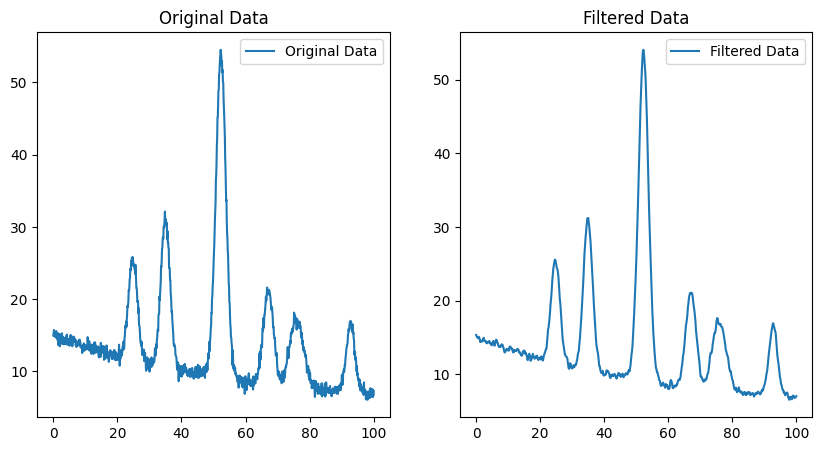

In [6]:
x3,y3 = spec_tools.baseline.generate_random_gaussian_with_shifted_baseline(10,[0,100],noise_level=0.5)
data3 = np.array([x3,y3]).T
spectrum3 = spec_tools.spectrum.Spectrum(name="Test-Data", data=data3)
baseline3 = spec_tools.baseline.Baseline(spectrum3)
baseline3.apply_savgol_filter(window_length=10)

# Polynomial Baseline Correction

A general polynomial has the form:

\begin{equation}
p(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + ... + \beta_n x^n = \sum_{i=0}^n \beta_i x^i
\end{equation}

where $\beta$ is the coefficient array of the polynomial. For polynomial fitting we use a least squares approach to minimize the residuals between the polynomial and the data.

\begin{equation}
\sum_{i=0}^n \left( y_i - p(x_i) \right)^2
\end{equation}

## Automated Selective Masking

For **Selective Masking** the goal is to remove the peaks from the data and keep only the raw baseline here we employ the following algorithm:

1. Pick the peaks using **scipy_signal.find_peaks** function
2. Fit a gaussian to the peaks to estimate the peak width
3. Add a error margin to the peak width
4. Create a mask of the data 
5. Fit a polynomial to the masked data

/home/lme/.conda/envs/molecular_m/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


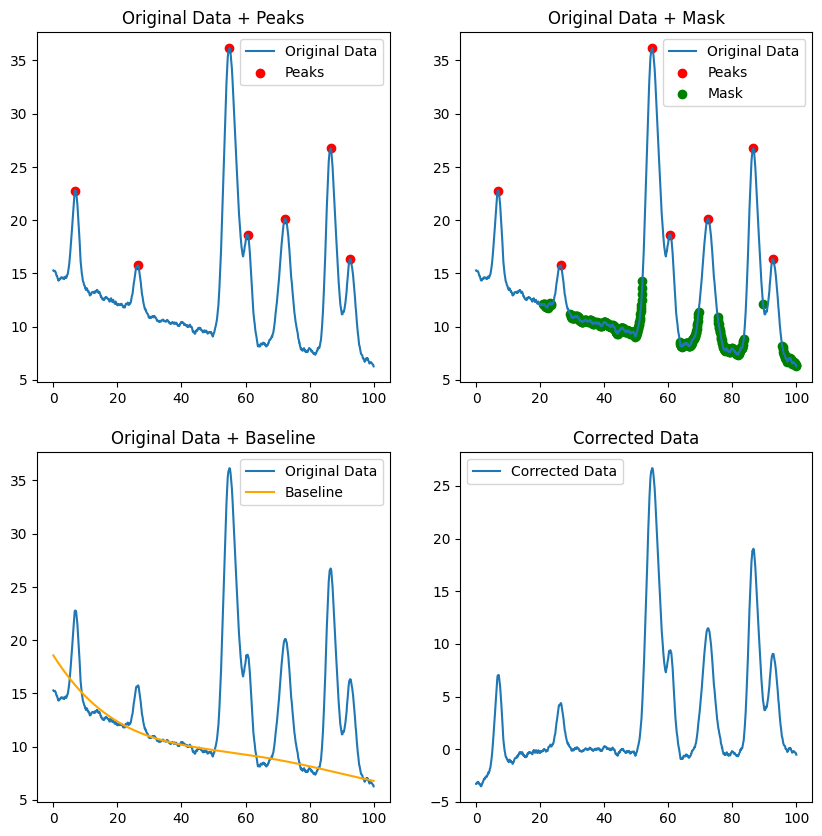

In [7]:
baseline1.selective_masking_poly_fit(peak_height=15.5,peak_distance=20,peak_width_guess=50,poly_order=4)

## Threshholding + modpoly()

Threshholding is a iterative fitting technique. The goal here is to take a chemical signal of the form

\begin{equation}
y(x_i) = b(x_i) +  s(x_i) + \epsilon(x_i)
\end{equation}

where $b(x_i)$ is the baseline, $s(x_i)$ is the signal and $\epsilon(x_i)$ is the noise. The goal is to estimate the baseline $b(x_i)$ and remove it from the data.

Steps:

1. For original signal $y_0$ set the power $n$
2. Establish a polynomial fitting equation
3. Calculate the result and compare with the signals, iterate this procedrue

0      15.283704
1      15.222819
2      15.225066
3      15.222962
4      15.224138
         ...    
995     6.490833
996     6.442231
997     6.427625
998     6.411469
999     6.273353
Name: y, Length: 1000, dtype: float64


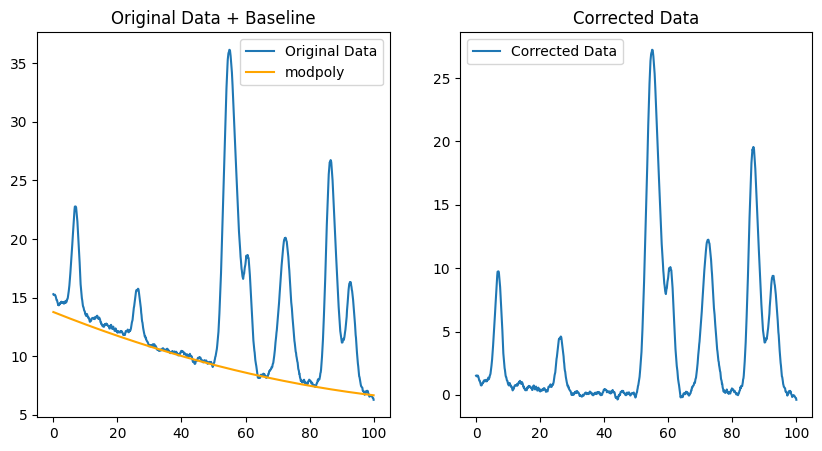

In [8]:
baseline1.modpoly_fit()

## Local Regression

Is also known as moving regression is a generalization of the moving average and polynomial regression.


+ Low degree polynomials are fitted to small subsets of data centered around each point of interest
+ Then we do a weighted regression, points closer to the target are given higher weights, while distant points have negligible inflcuence. The weights are determined by a kernel function


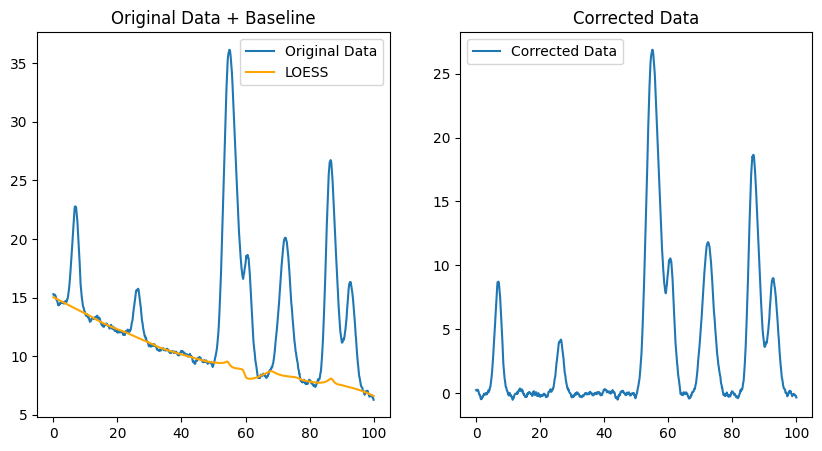

In [9]:
baseline1.loess_polynomial_fit()

# Whittaker Baselines

Whittaker-smoothing-based algorithms are normally referred to as weighted least squares or penalized least squares. 

Again we have a noise series of data $y$ of length $m$ and we want to fit a smooth series $z$ to the data. We balance two conflicting goals:

1. Fidelity of the data
2. Roughness of $z$

The smoother $z$ the more it will deviate from the data. Roughness can be expressed by using differences

$\Delta z_i = z_i - z_{i-1}$

This can be expressed as the sums of squares of the differences

\begin{equation}
R = \sum_i (\Delta z_i)^2
\end{equation}

Lack of fit can be expressed by the usual sums of squares of the differences between the data and the fitted values

\begin{equation}
S = \sum_i (y_i - z_i)^2
\end{equation}

A balanced combination of these two goals in given by $Q = S + \lambda R$ where $\lambda$ is a smoothing parameter. The larger the value of $\lambda$ the smoother the fitted curve will be. The smaller the value of $\lambda$ the closer the fitted curve will be to the data.


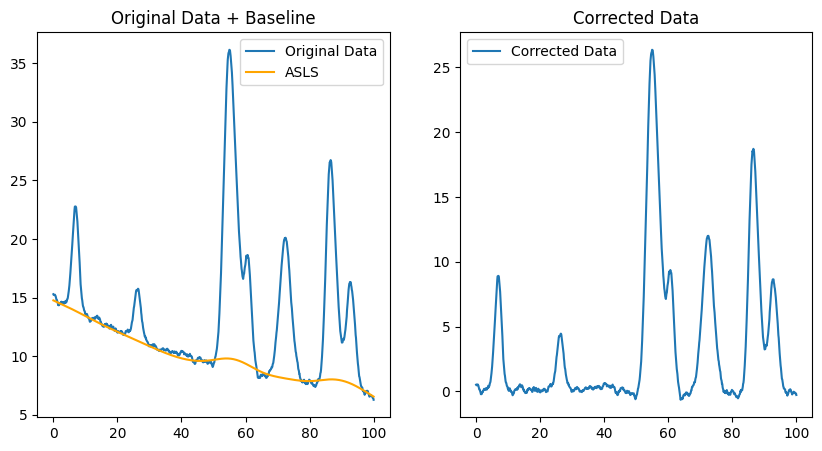

In [10]:
baseline1.asls_fit()

# Exploration of $\lambda$ Space

For validation and subsequent automatisation of the fitting procedure one can explore the $\lambda$ space. This is done by fitting the data with different values of $\lambda$ and calculating first the residuals.

We can use for example the **Ellbow** Method to find the optimal value of $\lambda$ that lies at an intermediate between a good fit and smoothing effect

...RSS values for the given lambda range...


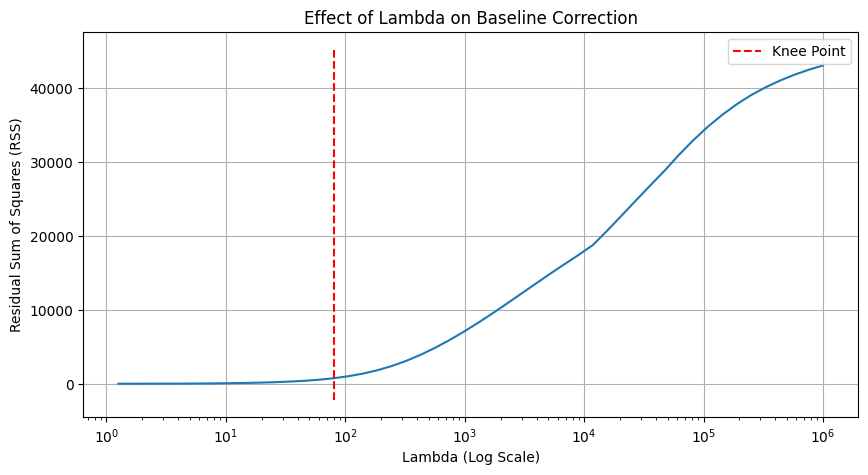

--------------- Optimal Lambda Value ----------------
Optimal Lambda Value: 80.56055490172109
-----------------------------------------------------


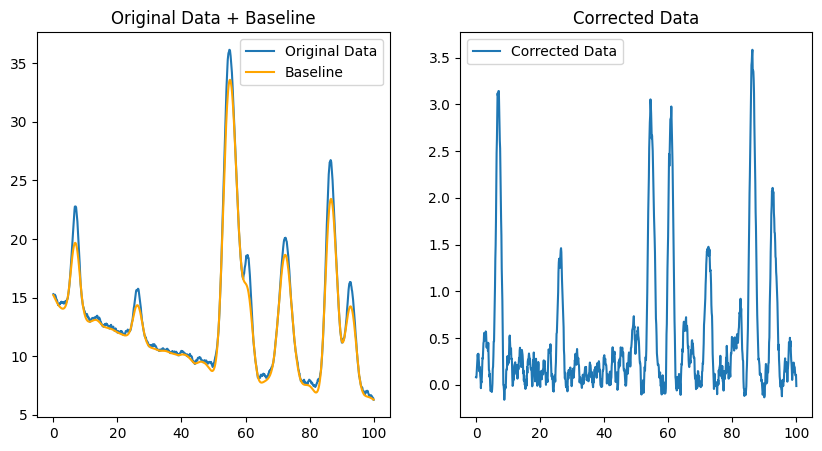

In [11]:
smoothed_baseline_1, lam_opt = baseline1.validate_lambda(lam_range=(0.1,6))

### Leave-One-Out Cross Validation

Another approach to obtain a good $\lambda$ value is to perform **Leave-One-Out Cross Validation** on your dataset. For this the algorithm is as follows:

1. We perform a k-fold cross validation where k is the number of data points
2. We remove a measurment and smooth the series
3. Then calculate the squared residuals between our curve and the removed measurement.
4. We Repeat this for every measurement and take the average of this procedure
5. And of course repeat for different values of $\lambda$

\begin{equation}
CVE = \frac{1}{n} \sum_{i=1} (y_i - f_{\lambda,-i}(x_i))^2
\end{equation}

...Performing LOOCV for the given Lambda range...


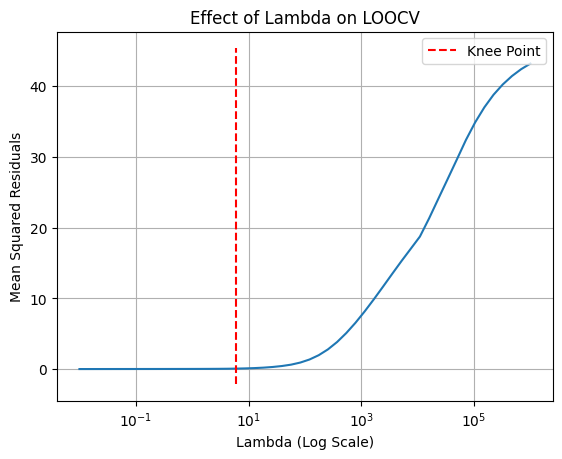

--------------- Optimal Lambda Value ----------------
Optimal Lambda Value: 5.963623316594643
-----------------------------------------------------


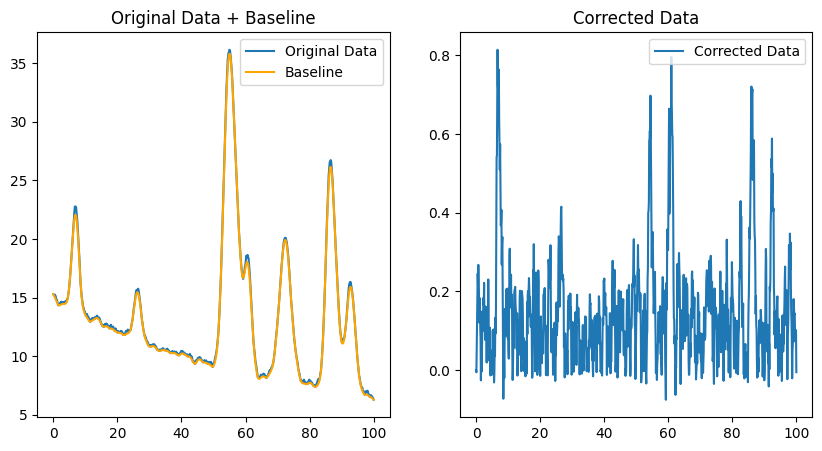

In [12]:
smoothed_baseline1, lam_opt = baseline1.loocv_lambda()

This procedure is computationally a little expensive, but is a good way to obtain a $\lambda$ value that **smooths** the data.

### Combination of both methods

One can now for example use this optimal $\lambda$ value to first smooth the data and then apply another baseline correction method

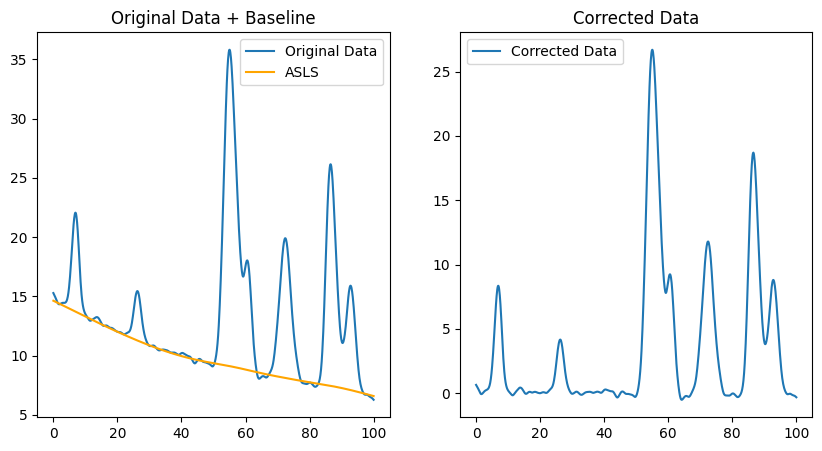

In [13]:
spectrum_smoothed = spec_tools.spectrum.Spectrum(name="Smoothed-Spectrum", data=smoothed_baseline1)
baseline_smoothed = spec_tools.baseline.Baseline(spectrum_smoothed)

baseline_smoothed.asls_fit(lam=1e7)


One can see in this plot that with very small $\lambda$ values the residueals are really small, this corresponds to more of a smoothing of the data. We can usethe function **plot_different_lambdas** to visualize this effect 

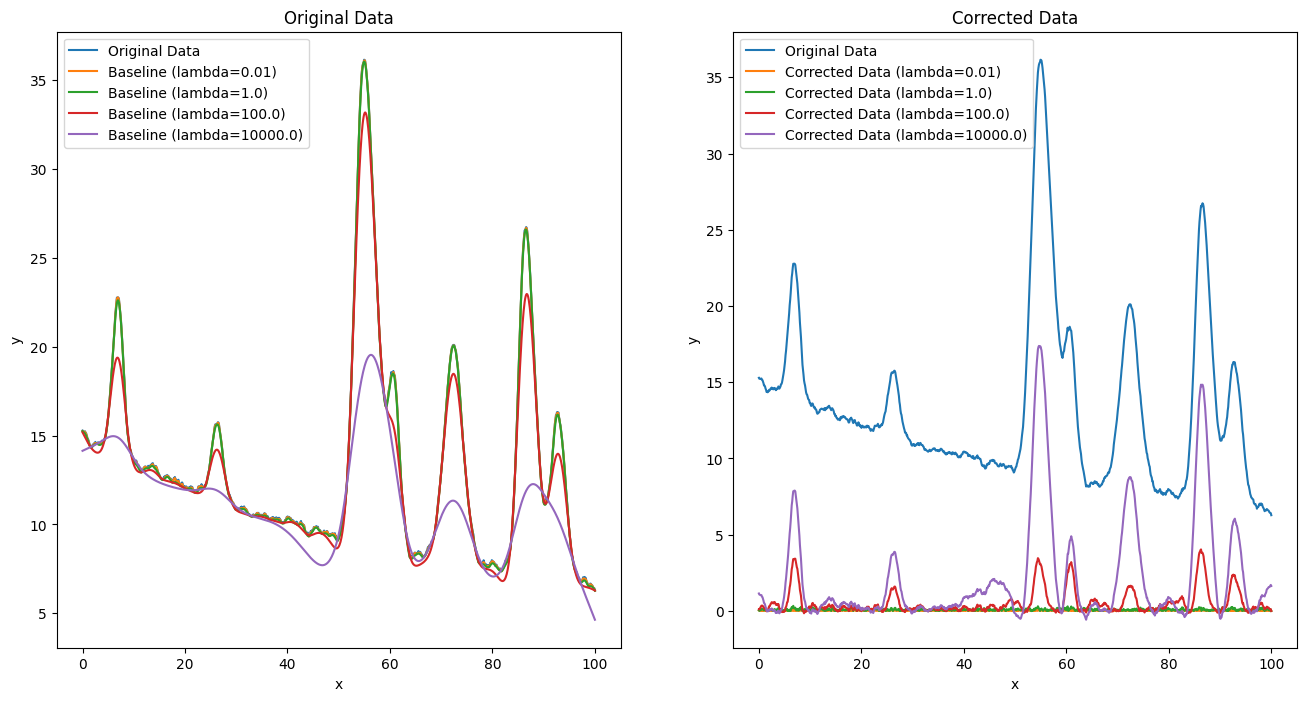

In [14]:
baseline1.plot_different_lambdas()

### Airpls (Adaptive iteratively reweighted penalized least squares)

This uses an exponential weighting of negative residuals to attempt to provide for a better fit than the normal asls method 

Again we have the minimization function

\begin{equation}
\sum_i^N w_i(y_i - v_i)^2 + \lambda \sum_i^N(\Delta^d v_i)^2
\end{equation}

This results in a linear system of the form

\begin{equation}
(W  +\lambda D^T D)y = W y
\end{equation}

Where $W$ is a diagonal matrix with the weights and $D$ is the difference matrix.


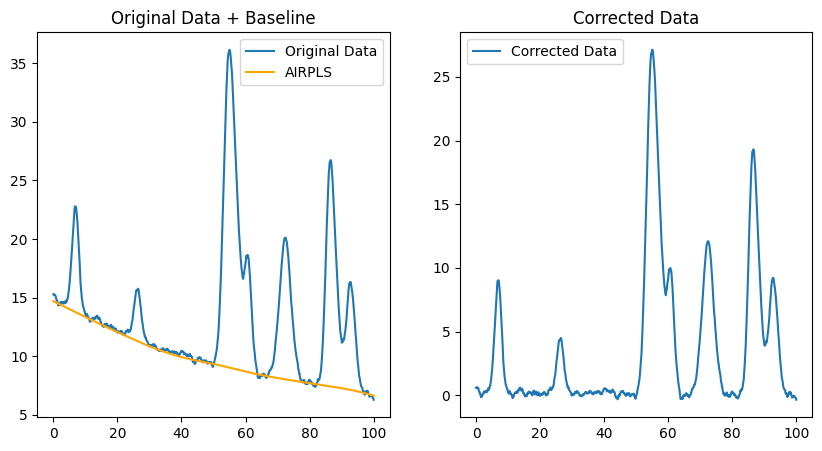

In [15]:
baseline1.airpls()

# Spline Baseline Fitting

Spline is a piecewise joining of individual curves. Different methods of B-splines are implemented in the **spec_tools** package.

A B-spline can be expressed by the following equation:

\begin{equation}
v(x) = \sum_i^N \sum_j^M B_j(x_i)c_j
\end{equation}

here $N$ is the number of points in $x$, $M$ is the number of spline basis functions, $B_j(x_i)$ is the j-th basis function evaluated at the i-th point and $c_j$ is the j-th coefficient of the spline. The coefficients are determined by minimizing the residuals between the data and the spline. This is done by solving a linear system of equations of the form:

When using regular B-spline fitting the spline coefficients are determined by using least-squares fitting.

\begin{equation}
\sum_i^N w_i(y_i - \sum_j^M B_j(x_i)c_j)^2
\end{equation}



In [ ]:
baseline1.irsqr_fitting()